<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/2023/lab2/solutions/Part2_FaceDetection_Solution.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/2023/lab2/solutions/Part2_FaceDetection_Solution.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [1]:
# Copyright 2023 MIT Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 2: Computer Vision

# Part 2: Diagnosing Bias in Facial Detection Systems

In this lab, we'll explore a prominent aspect of applied deep learning for computer vision: facial detection. 

Consider the task of facial detection: given an image, is it an image of a face?  This seemingly simple -- but extremely important and pervasive -- task is subject to significant amounts of algorithmic bias among select demographics, as [seminal studies](https://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf) have shown.

Deploying fair, unbiased AI systems is critical to their long-term acceptance. In this lab, we will build computer vision models for facial detection. We will extend beyond that to build a model to **uncover and diagnose** the biases and issues that exist with standard facial detection models. To do this, we will build a semi-supervised variational autoencoder (SS-VAE) that learns the *latent distribution* of features underlying face image datasets in order to [uncover hidden biases](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf).

Our work here will set the foundation for the next lab, where we'll build automated tools to mitigate the underlying issues of bias and uncertainty in facial detection.

Let's get started by installing the relevant dependencies:

In [2]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning
import mitdeeplearning as mdl

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.3.0-py3-none-any.whl size=2117316 sha256=0b82e46f40b1ec3d91f1b8e091c100ec20e54604600bbbb4889fc7bbee8b84ad
  Stored in directory: /root/.cache/pip/wheels/fb/36/e6/2c0d1df845f0cc8152c7a32b3663af9b03a79400a975a12aff
Successfully built mitdeeplearning


## 2.1 Datasets

In order to train our facial detection models, we will need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We will use these data to train our models to classify images as either faces or not faces.

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale dataset (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). A large-scale dataset with many images across many different categories. We will take negative examples from a variety of non-human categories.

We will evaluate trained models on an independent test dataset of face images to diagnose potential issues with *bias, fairness, and confidence*.

Let's begin by importing these datasets. We've written a class that does a bit of data pre-processing to import the training data in a usable format.

In [3]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1263889489/1263889489 [==============================] - 18s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


We can look at the size of the training dataset and grab a batch of size 100:

In [4]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

Play around with displaying images to get a sense of what the training data actually looks like!

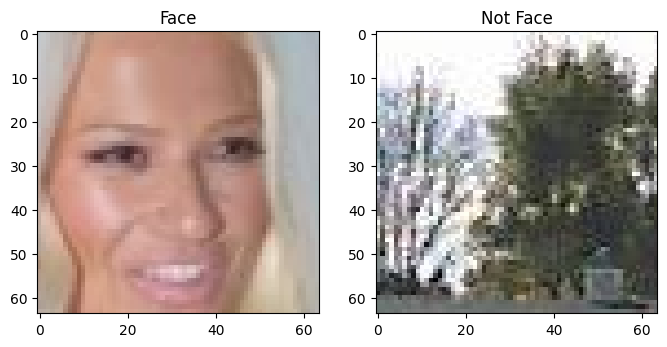

In [5]:
#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

### Examining the CelebA training dataset ###

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 19 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 8 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

### Thinking about bias

We will be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluate their accuracy as well as inspect and diagnose their hidden flaws. Our goal is to identify any potential issues and biases that may exist with the trained facial detection classifiers, and then diagnose what those issues and biases are.

What exactly do we mean when we say a classifier is biased? In order to formalize this, we'll need to think about [*latent variables*](https://en.wikipedia.org/wiki/Latent_variable), variables that define a dataset but are not strictly observed. As defined in the generative modeling lecture, we use the term *latent space* to refer to the probability distributions of the aforementioned latent variables. Putting these ideas together, we consider a classifier *biased* if its classification decision changes after it sees some additional latent features or variables. This definition of bias will be helpful to keep in mind throughout the rest of the lab.

## 2.2 CNN for facial detection 

First, we will define and train a baseline CNN on the facial detection task of classifying whether a given image is a face, or is not a face. We will then evaluate its accuracy. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction. 

### Define and train the CNN model

Like we did in the first part of the lab, we will define our CNN model, and then train on the CelebA and ImageNet datasets using the `tf.GradientTape` class and the `tf.GradientTape.gradient` method.

In [6]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([ 
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

Now let's train the standard CNN!

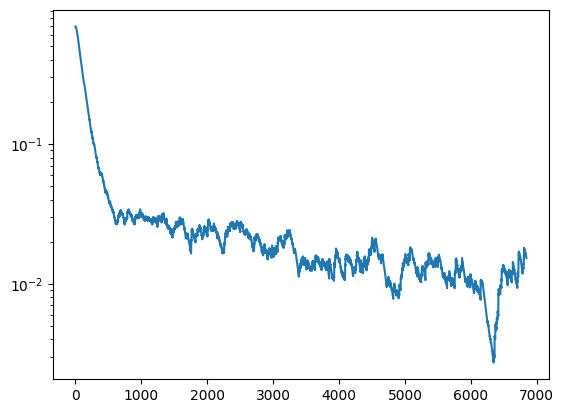

100%|██████████| 3434/3434 [04:37<00:00, 12.38it/s]


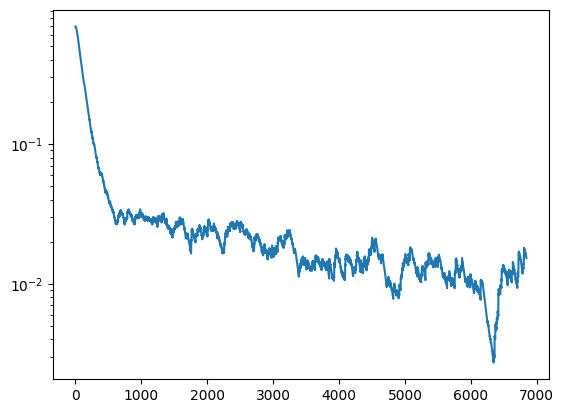

In [7]:
### Train the standard CNN ###

# Training hyperparameters
batch_size = 32
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x) 
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

### Evaluate performance of the standard CNN

Next, let's evaluate the classification performance of our CelebA-trained standard CNN on the training dataset.


In [8]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 3s 19ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9972


## 2.3 Diagnosing algorithmic bias

CNNs like the one we just built are pervasive as the standard solution for facial detection pipelines implemented throughout society. Despite their pervasiveness, these models -- including those implemented by top tech companies -- suffer from tremendous amounts of algorithmic bias. The seminal work of [Buolamwini and Gebru](https://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf) provided an approach and benchmark dataset to evaluate facial analysis algorithms, revealing startling accuracy discrepancies across skin tone and gender demographics.

In order to solve this problem and build fair and robust models, the first step is to determine the source of the problem. How can we determine the ***source*** of these accuracy discrepancies to identify and diagnose biases?

### Naive approach

A naive approach -- and one that is being adopted by many companies and organizations -- would be to annotate different subclasses (i.e., light-skinned females, males with hats, etc.) within the training data, and then evaluate classifier performance with respect to these groups.

But this approach has two major disadvantages. First, it requires annotating massive amounts of data, which is not scalable. Second, it requires that we know what potential biases (e.g., race, gender, pose, occlusion, hats, glasses, etc.) to look for in the data. As a result, manual annotation may not capture all the different sources of bias and uncertainty that may exist.

### Automatically uncovering hidden biases

Imbalances in the training data can result in unwanted algorithmic bias. For example, the majority of faces in CelebA (our training set) are those of light-skinned females. As a result, a classifier trained on CelebA will be better suited at recognizing and classifying faces with features similar to these, and will thus be biased.

What if we actually ***learned*** the distribution of data features in an unbiased, unsupervised manner, without the need for any annotation? What could such an approach tell us about hidden biases that may exist in the data, or regions of the data in which the model is less confident in its predictions?

In the rest of this lab, we will tackle exactly these questions.

## 2.4 Variational autoencoder (VAE) for learning latent structure

The accuracy of facial detection classifiers can vary significantly across different demographics. Consider the dataset the CNN model was trained on, CelebA. If certain features, such as dark skin or hats, are *rare* in CelebA, the model may end up biased against these as a result of training with a biased dataset. That is to say, its classification accuracy will be worse on faces that have under-represented features, such as dark-skinned faces or faces with hats, relevative to faces with features well-represented in the training data! This is a problem.

Our goal is to train a model that **learns a representation of the underlying latent space** to the face training data. Such a learned representation will provide information on what features are under-represented or over-represented in the data. The key design requirement for our model is that it can learn an *encoding* of the latent features in the face data in an entirely *unsupervised* way, without any supervised annotation by us humans. To achieve this, we turn to variational autoencoders (VAEs).

![The concept of a VAE](https://i.ibb.co/3s4S6Gc/vae.jpg)

As shown in the schematic above and in Lecture 4, VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn. 

Let's formalize two key aspects of the VAE model and define relevant functions for each.

### Understanding VAEs: loss function

In practice, how can we train a VAE? In learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are learned parameters, and therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. What this means is that we'll have two terms in our VAE loss function:

1.  **Latent loss ($L_{KL}$)**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.
2.   **Reconstruction loss ($L_{x}{(x,\hat{x})}$)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstructed output.

The equation for the latent loss is provided by:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

The equation for the reconstruction loss is provided by:

$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

Thus for the VAE loss we have:

$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

where $c$ is a weighting coefficient used for regularization. Now we're ready to define our VAE loss function:

In [9]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
  # in the text block directly above
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  # latent_loss = # TODO

  # TODO: Define the reconstruction loss as the mean absolute pixel-wise 
  # difference between the input and reconstruction. Hint: you'll need to 
  # use tf.reduce_mean, and supply an axis argument which specifies which 
  # dimensions to reduce over. For example, reconstruction loss needs to average 
  # over the height, width, and channel image dimensions.
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  # reconstruction_loss = # TODO

  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  # vae_loss = # TODO
  
  return vae_loss

### Understanding VAEs: sampling and reparameterization 

As you may recall from lecture, VAEs use a "reparameterization  trick" for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample a noise value $\epsilon$ from a Gaussian distribution, and then scale it by the standard deviation and add back the mean to output the result as our sampled latent vector. Formalizing this for a latent variable $z$ where we sample $\epsilon \sim N(0,(I))$ we have:

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

where $\mu$ is the mean and $\Sigma$ is the covariance matrix. This is useful because it will let us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!

Let's define a function to implement the VAE sampling operation:

In [10]:
### VAE Sampling ###

"""Sample latent variables via reparameterization with an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  # z = # TODO
  return z

Great! Now that we have a more concrete sense of how VAEs work, let's explore how we can leverage this network structure to diagnoses hidden biases in facial detection classifiers.

## 2.5 Semi-supervised variational autoencoder (SS-VAE)

Now, we will use the general idea behind the VAE architecture to build a model to automatically uncover (potentially) unknown biases present within the training data, while simultaneously learning the facial detection task. This draws direct inspiration from [a recent paper](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf) proposing this as a general approach for automatic bias detetion and mitigation.


### Semi-supervised VAE architecture

We will develop a VAE that has a supervised component in order to both output a classification decision for the facial detection task and analyze where the biases in our model may be resulting from. While previous works like that of  Buolamwini and Gebru have focused on skin tone and gender as two categories where facial detection models may be experiencing bias, there may be other unlabeled features that also are biased, resulting in poorer classification performance. We will build our semi-supervised VAE (SS-VAE) to learn these underlying latent features.

A general schematic of the SS-VAE architecture is shown here.

![SS-VAE](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/SS-VAE.png)

We will apply our SS-VAE to a *supervised classification* problem -- the facial detection task. Importantly, note how the encoder portion in the SS-VAE architecture also outputs a single supervised variable, $z_o$, corresponding to the class prediction -- face or not face. Usually, VAEs are not trained to output any supervised variables (such as a class prediction)! This is the key distinction between the SS-VAE and a traditional VAE. 

Keep in mind that we only want to learn the latent representation of *faces*, as that is where we are interested in uncovering potential biases, even though we are training a model on a binary classification problem. So, we will need to ensure that, **for faces**, our SS-VAE model both learns a representation of the unsupervised latent variables, captured by the distribution $q_\phi(z|x)$, and outputs a supervised class prediction $z_o$, but that, **for negative examples**, it only outputs a class prediction $z_o$.

### Defining the SS-VAE loss function

This means we'll need to be a bit clever about the loss function for the SS-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered. 

For **face images**, our loss function will have two components:

1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem. 

In contrast, for images of **non-faces**, our loss function is solely the classification loss. 

We can write a single expression for the loss by defining an indicator variable ${I}_f$which reflects which training data are images of faces (${I}_f(y) = 1$ ) and which are images of non-faces (${I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + {I}_f(y)\Big[L_{VAE}\Big]$$

Let's write a function to define the SS-VAE loss function:


In [11]:
### Loss function for SS-VAE ###

"""Loss function for SS-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: SS-VAE total loss
    classification_loss: SS-VAE classification loss
"""
def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # TODO: call the relevant function to obtain VAE loss, defined earlier in the lab
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  # vae_loss = vae_loss_function('''TODO''') # TODO

  # TODO: define the classification loss using sigmoid_cross_entropy
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  # classification_loss = # TODO

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # TODO: define the SS-VAE total loss! Use tf.reduce_mean to average over all
  # samples
  total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
  )
  # total_loss = # TODO

  return total_loss, classification_loss, vae_loss

### Defining the SS-VAE architecture

Now we're ready to define the SS-VAE architecture. To build the SS-VAE, we will use the standard CNN classifier from above as our encoder, and then define a decoder network. We will create and initialize the encoder and decoder networks, and then construct the end-to-end VAE. We will use a latent space with 32 latent variables.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers, and output a reconstruction of the original input image.

In [12]:
### Define the decoder portion of the SS-VAE ###

def make_face_decoder_network(n_filters=12):

  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

Now, we will put this decoder together with the standard CNN classifier as our encoder to define the SS-VAE. Here, we will define the core VAE architecture by sublassing the `Model` class; defining encoding, sampling, and decoding operations; and calling the network end-to-end.

In [13]:
### Defining and creating the SS-VAE ###

class SS_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(SS_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder (self.decoder) to output the reconstruction
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: call the sampling function that you created above using 
    #       z_mean and z_logsigma
    z = sampling(z_mean, z_logsigma)
    # z = # TODO

    # TODO: reconstruction
    recon = self.decode(z)
    # recon = # TODO
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

ss_vae = SS_VAE(latent_dim=32)

As stated, the encoder architecture is identical to the CNN from earlier in this lab. Note the outputs of our constructed SS-VAE model in the `call` function: `y_logit, z_mean, z_logsigma, z`. Think carefully about why each of these are outputted and their significance to the problem at hand.



### Training the SS-VAE

We are ready to train our SS-VAE model! Complete the `TODO`s in the following training loop to train the SS-VAE with face classification output.

Starting epoch 6/6


  0%|          | 0/3434 [00:00<?, ?it/s]

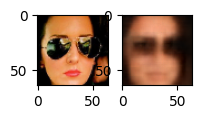

 15%|█▍        | 500/3434 [01:03<07:27,  6.56it/s]

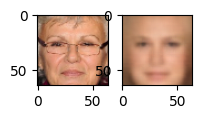

 29%|██▉       | 1000/3434 [02:07<04:43,  8.58it/s]

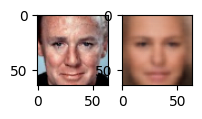

 44%|████▎     | 1500/3434 [03:10<03:39,  8.80it/s]

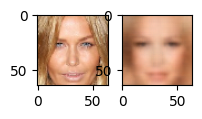

 58%|█████▊    | 2000/3434 [04:14<02:37,  9.11it/s]

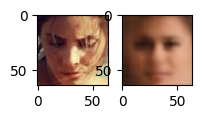

 73%|███████▎  | 2500/3434 [05:18<02:02,  7.63it/s]

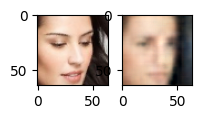

 87%|████████▋ | 3000/3434 [06:22<00:51,  8.50it/s]

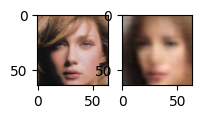

100%|██████████| 3434/3434 [07:18<00:00,  7.82it/s]


In [14]:
### Training the SS-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 32

# SS-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 6

# instantiate a new SS-VAE model and optimizer
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def ss_vae_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into ss_vae. Note that this is using the SS_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)

    '''TODO: call the SS_VAE loss function to compute the loss'''
    loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    # loss, class_loss = ss_vae_loss_function('''TODO arguments''') # TODO
  
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the SS_VAE.'''
  grads = tape.gradient(loss, ss_vae.trainable_variables)
  # grads = tape.gradient('''TODO''', '''TODO''') # TODO

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))
  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size)
    # loss optimization
    loss = ss_vae_train_step(x, y)
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, ss_vae)

Wonderful! Now we should have a trained SS-VAE facial classification model, ready for evaluation!

## 2.6 Using the SS-VAE to uncover and diagnose biases

With the SS-VAE model trained, we are ready to use it to uncover and diagnose hidden biases that exist within the dataset.

Recall that our goal with the SS-VAE was to learn the underlying ***latent distribution*** of features in the training dataset, in order to uncover potential feature representation disparities that exist within the data.

Additionally, training the SS-VAE required both a VAE reconstruction loss as well as a supervised classification loss. The VAE reconstruction loss direclty reflects how well the model is able to handle particular input data -- the higher the reconstruction loss, the harder that particular example is for the model to learn.

We consider both these aspects to understand sources of uncertainty and bias within the model.

### Linking model performance to uncertainty and bias

We begin by considering the examples in the dataset with the highest loss. What can you tell about which features seemed harder to learn for the VAE? What might this tell us about where the model struggles, and what predictions it may be more biased or uncertain about?

#### **TODO: Analysis and reflection**

Complete the analysis in the code block below. Write short (~1 sentence) answers to the following questions and include them in your Debiasing Faces Lab submission to complete the `TODO`s!

1. What, if any, trends do you observe comparing the samples with the highest and lowest reconstruction loss?
2. Based on these observations, which features seemed harder to learn for the VAE?
3. How does reconstruction loss relate to uncertainty? Think back to our lecture on Robust & Trustworthy Deep Learning! What can you say about examples on which the model may be more or less uncertain?

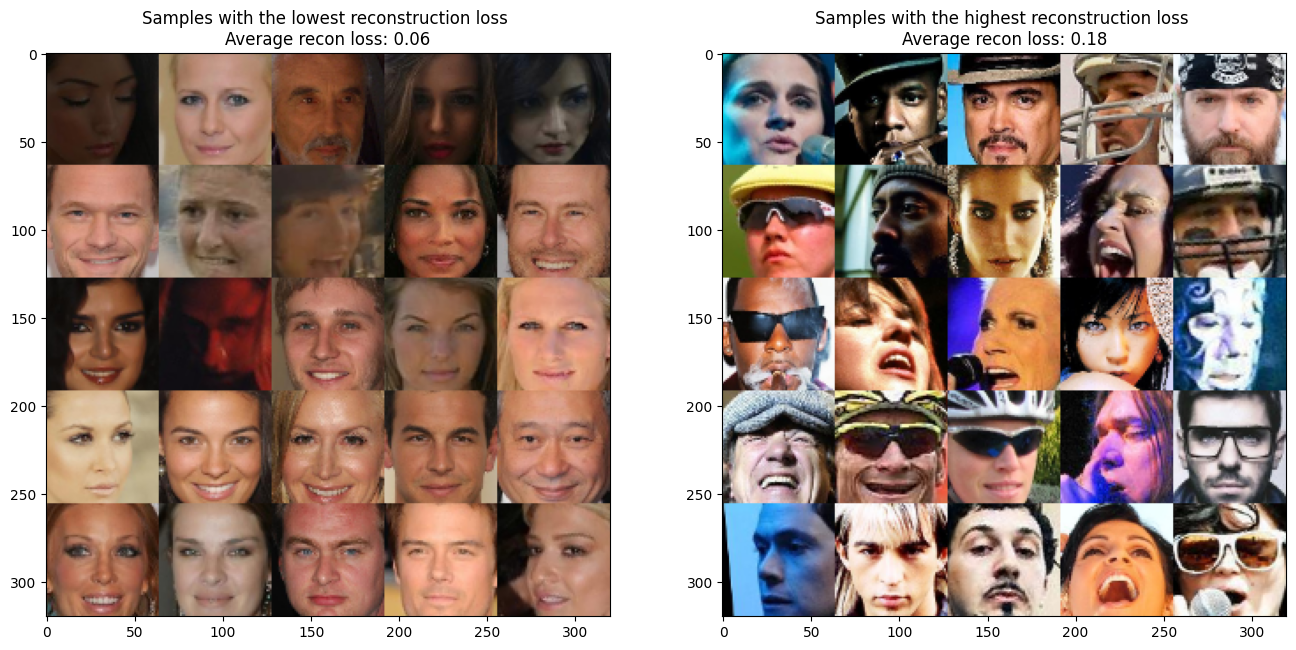

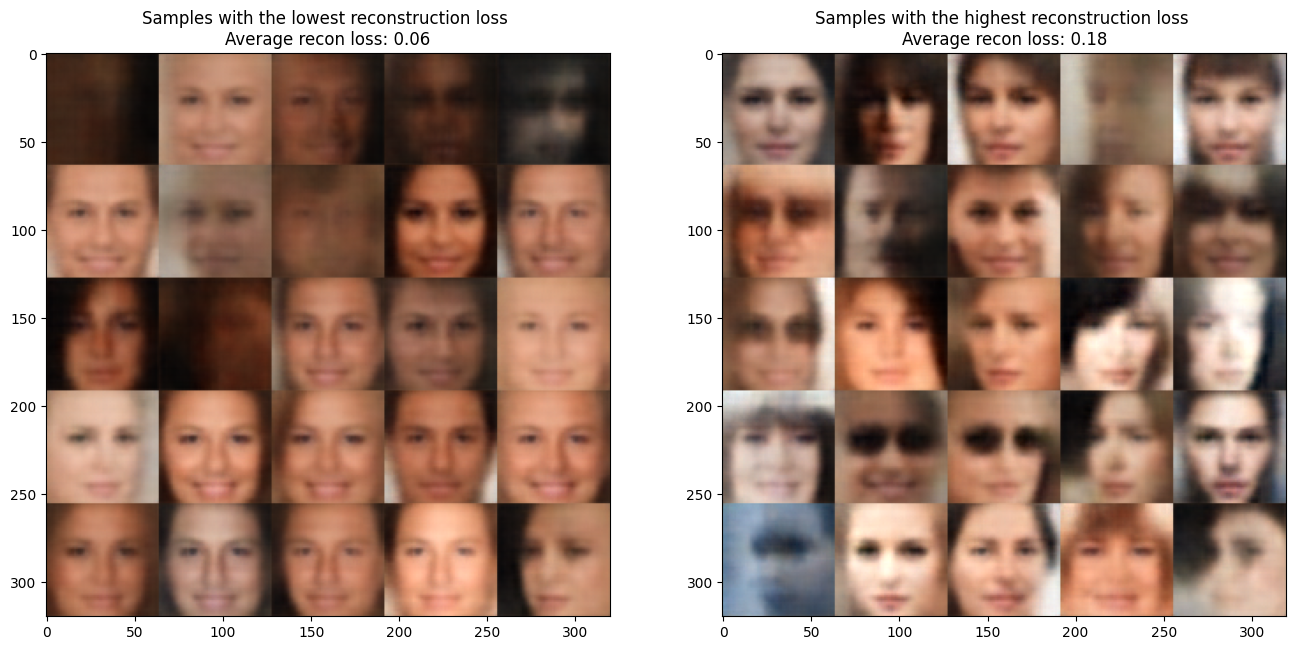

In [59]:
### Linking model performance to uncertainty and bias

# Load a random sample of 5000 faces from our dataset and compute the model performance on them
(x, y) = loader.get_batch(5000, only_faces=True)
y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

# Sort the results by the vae loss scores
vae_loss = vae_loss.numpy()
ind = np.argsort(vae_loss, axis=None)

# Plot the 25 samples with the highest and lowest reconstruction losses
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(x[ind[:25]]))
ax[0].set_title("Samples with the lowest reconstruction loss \n" + 
                f"Average recon loss: {np.mean(vae_loss[ind[:25]]):.2f}")

ax[1].imshow(mdl.util.create_grid_of_images(x[ind[-25:]]))
ax[1].set_title("Samples with the highest reconstruction loss \n" + 
                f"Average recon loss: {np.mean(vae_loss[ind[-25:]]):.2f}");

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(x_recon.numpy()[ind[:25]]))
ax[0].set_title("Samples with the lowest reconstruction loss \n" + 
                f"Average recon loss: {np.mean(vae_loss[ind[:25]]):.2f}")

ax[1].imshow(mdl.util.create_grid_of_images(x_recon.numpy()[ind[-25:]]))
ax[1].set_title("Samples with the highest reconstruction loss \n" + 
                f"Average recon loss: {np.mean(vae_loss[ind[-25:]]):.2f}");

### Uncovering hidden biases through learned latent features 

As we've seen above, loss is a powerful way to visualize which samples in our dataset the model has had trouble learning -- these examples are those that have high *model uncertainty*. However, this is not necessarily the same as bias!

How can we determine the relative frequencies and distributions of different latent features learned by the model? How may these metrics reveal underlying biases?

Let's investigate how well the SS-VAE actually learned the latent features of the faces. To do this, we will inspect individual latent features -- holding all others constant -- and look at the distribution of these features in the data and their corresponding examples. We can examine the shape and probability density of the learned latent features. Further we directly compare different values of individual latent variables to corresponding relative classification accuracies (marginalizing out the effects of the other latent variables).

#### **TODO: Analysis and reflection**

Complete the analysis in the code blocks below. Carefully inspect the different latent variables and their corresponding frequency distributions. Write short (~1 sentence) answers to the following questions and include them in your Debiasing Faces Lab submission to complete the `TODO`s!

1. Pick two latent variables and describe what semantic meaning they reflect. Include screenshots of the realizations and probability distribution for the latent variables you select.
2. For the latent variables selected, what can you tell about which features are under- or over-represented in the data? What might this tell us about how the model is biased?
3. For the latent variables selected, how do these feature distribution differences affect classification performance? What, if any, general trends do you observe across the latent variables?
4. Based on these observations, please describe your understanding of the bias of the facial detection classifier.

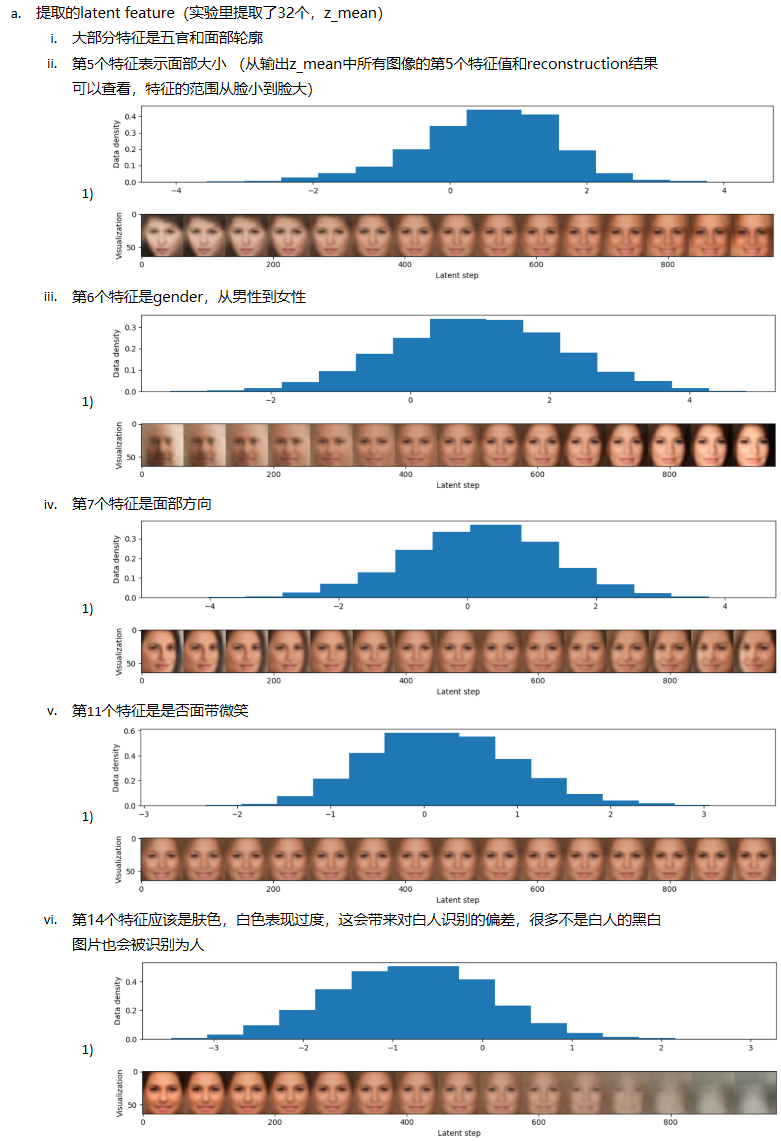

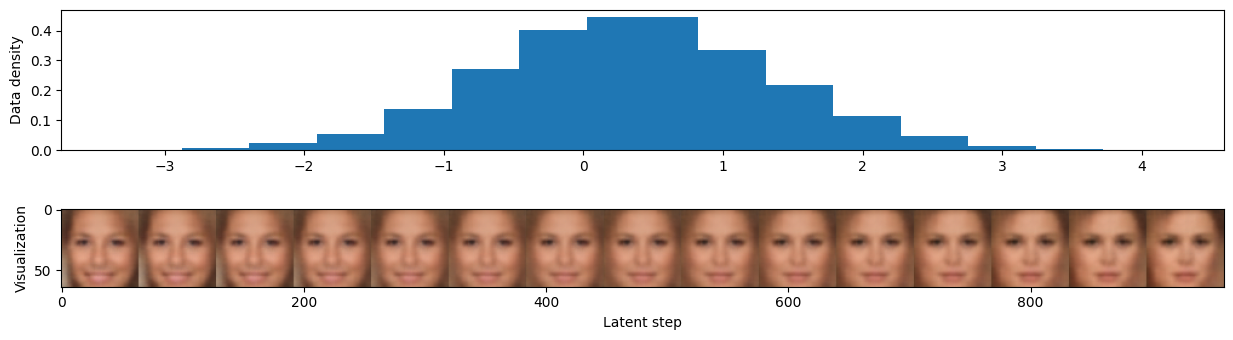

In [85]:
### Inspect different latent features

#@title Change the sliders to inspect different latent features! { run: "auto" }
idx_latent = 29 #@param {type:"slider", min:0, max:31, step:1}
num_steps = 15

# Extract all latent samples from the desired dimension
# 所有5000张图像中提取的第idx_latent个特征
latent_samples = z_mean[:, idx_latent]

# Compute their density and plot
# 该特征的分布情况
density, latent_bins = np.histogram(latent_samples, num_steps, density=True)
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].bar(latent_bins[1:], density)
ax[0].set_ylabel("Data density")

# Visualize reconstructions as we walk across the latent space
# 抽样查看5000张图像提取出的第idx_latent个特征，baseline是特征平均值
latent_steps = np.linspace(np.min(latent_samples), np.max(latent_samples), num_steps)
baseline_latent = tf.reduce_mean(z_mean, 0, keepdims=True)

recons = []
for step in latent_steps: 
  # Adjust the latent vector according to our step
  latent = baseline_latent.numpy()
  latent[0, idx_latent] = step

  # Decode the reconstruction and store
  recons.append(ss_vae.decode(latent)[0])

# Visualize all of the reconstructions!
ax[1].imshow(mdl.util.create_grid_of_images(recons, (1, num_steps)))
ax[1].set_xlabel("Latent step")
ax[1].set_ylabel("Visualization");



### Inspect how the accuracy changes as a function of density in the latent space


Text(0, 0.5, 'Relative accuracy')

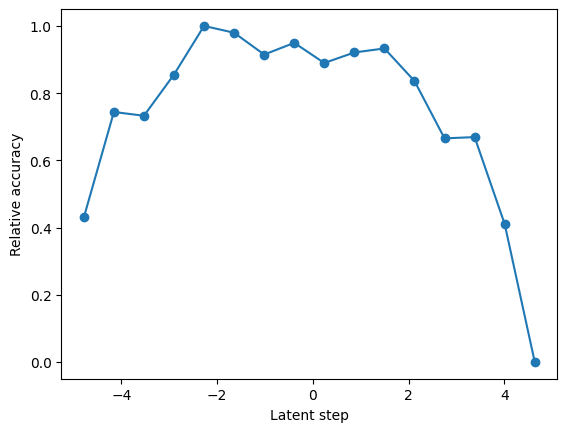

In [17]:
### Accuracy vs. density in latent space

# Loop through every latent dimension
avg_logit_per_bin = []
for idx_latent in range(latent_dim): 
  latent_samples = z_mean[:, idx_latent]
  start = np.percentile(latent_samples, 5)
  end = np.percentile(latent_samples, 95)
  latent_steps = np.linspace(start, end, num_steps)

  # Find which samples fall in which bin of the latent dimension
  which_latent_bin = np.digitize(latent_samples, latent_steps)
  
  # For each latent bin, compute the accuracy (average logit score)
  avg_logit = []
  for j in range(0, num_steps+1): 
    inds_in_bin = np.where(which_latent_bin == j)
    avg_logit.append(y_logit.numpy()[inds_in_bin].mean())

  avg_logit_per_bin.append(avg_logit)
  
# Average the results across all latent dimensions and all samples
accuracy_per_latent = np.mean(avg_logit_per_bin, 0)
accuracy_per_latent = (accuracy_per_latent - accuracy_per_latent.min()) / np.ptp(accuracy_per_latent)

# Plot the results
plt.plot(np.linspace(np.min(z_mean), np.max(z_mean), num_steps+1), accuracy_per_latent,'-o')
plt.xlabel("Latent step")
plt.ylabel("Relative accuracy")

## 2.8 Conclusion and submission information

**To be eligible for the Debiasing Faces Lab prize, you must submit a document of your answers to the short-answer `TODO`s with your complete lab submission.** Please see the short-answer `TODO`s replicated again here:

#### **TODO: Linking model performance to uncertainty and bias**

1. What, if any, trends do you observe comparing the samples with the highest and lowest reconstruction loss?
2. Based on these observations, which features seemed harder to learn for the VAE?
3. How does reconstruction loss relate to uncertainty? Think back to our lecture on Robust & Trustworthy Deep Learning! What can you say about examples on which the model may be more or less uncertain?

#### **TODO: Uncovering hidden biases through learned latent features**

1. Pick two latent variables and describe what semantic meaning they reflect. Include screenshots of the realizations and probability distribution for the latent variables you select.
2. For the latent variables selected, what can you tell about which features are under- or over-represented in the data? What might this tell us about how the model is biased?
3. For the latent variables selected, how do these feature distribution differences affect classification performance? What, if any, general trends do you observe across the latent variables?
4. Based on these observations, please describe your understanding of the bias of the facial detection classifier.

**To enter the competition, you must upload a document write-up as part of your complete lab submission for the Debiasing Faces Lab ([submission upload link](https://www.dropbox.com/request/TTYz3Ikx5wIgOITmm5i2)).** Complete details on submission are included in the next lab!


## 2.9 Thinking ahead

Beyond this, we encourage you to think about the following questions as you prepare for the next lab, which will focus on mitigating the issues of bias and uncertainty that you just uncovered. Consider:
* How do the samples with highest reconstruction loss and samples with highest bias compare? Which features is each one highlighting? Why do you think this is?
* In what ways is the dataset biased so far? Can you imagine other features that the dataset is biased against that we have not uncovered yet?
*  How can the performance of the supervised VAE classifier be improved?
* Do you have ideas for other ways to address issues of bias, particularly in terms of the training data?

Hopefully this lab has shed some light on a few concepts, from vision based tasks, to VAEs, to algorithmic bias. We like to think it has, but we're biased ;).

<img src="https://i.ibb.co/BjLSRMM/ezgif-2-253dfd3f9097.gif" />